In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import time
import os
import copy
from google.colab import drive 
#from tqdm import tqdm
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, confusion_matrix, hamming_loss, multilabel_confusion_matrix
import pandas as pd
from tabulate import tabulate
from PIL import Image

In [2]:
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive


In [0]:
!unzip "A_05_Part_02_Dataset.zip"

In [0]:
class TestDataset(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.all_images = sorted(os.listdir(main_dir),key=lambda f: int(f.split('.')[0]))
        self.total_images = (self.all_images)

    def __listName__(self):
        return self.all_images

    def __len__(self):
        return len(self.total_images)

    def __getitem__(self, index):
        images_loc = os.path.join(self.main_dir, self.total_images[index])
        image = Image.open(images_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [0]:
# class for Focal Loss

class FocalLoss(nn.Module):

    def __init__(self, gamma = 2.0, alpha = 1.0):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, input_, target):
        
        BCE_Loss = nn.BCEWithLogitsLoss()(input_, target)
        p_t = torch.exp(-BCE_Loss)
        focal_loss = self.alpha * (1-p_t)**self.gamma * BCE_Loss
  
        return torch.mean(focal_loss)

In [0]:
data_dir_Train = '/content/gdrive/My Drive/A_05_Part_02_Dataset/Train'
data_dir_Test = '/content/gdrive/My Drive/A_05_Part_02_Dataset/Test'
data_dir_valid = '/content/gdrive/My Drive/A_05_Part_02_Dataset/Validation'


In [7]:
#Define transforms for the training data and testing data
#pass transform here-in
train_transforms = transforms.Compose([transforms.Resize((224,224), interpolation=2),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(root=data_dir_Train, transform=train_transforms)
#test_data = datasets.ImageFolder(root=data_dir_Test, transform=train_transforms)
test_data = TestDataset(data_dir_Test, transform=train_transforms)
valid_data = datasets.ImageFolder(root=data_dir_valid, transform=train_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=8)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True,num_workers=8)

print("Training Data Classes: ")
class_names_Train = train_data.classes
print(class_names_Train)

print("Validation Data Classes: ")
class_names_Valid = valid_data.classes
print(class_names_Valid)

#print("Test Data Classes: ")
#class_names_Test = test_data.classes
#print(class_names_Test)

Training Data Classes: 
['covid-19', 'normal', 'pneumonia']
Validation Data Classes: 
['covid', 'normal', 'pneumonia']


In [8]:
print('Valid number of batches',len(validloader))
print('Training number of batches',len(trainloader))
print('Test number of batches',len(testloader))

Valid number of batches 10
Training number of batches 97
Test number of batches 10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


here man torch.Size([128, 3, 224, 224])
in function (228, 1584, 3)


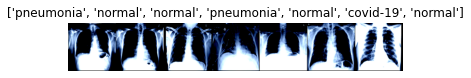

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    print('in function', inp.shape)
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names_Train[x] for x in classes])

# Get a batch of training data
#trainloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
inputs, classes = next(iter(trainloader))
print('here man', inputs.shape)
show_databatch(inputs[0:7], classes[0:7])

In [0]:
def one_hot_encoding(labels_input):
    new_label = []
    
    for i in range (labels_input.size(0)):
        if labels_input[i] == 1:
            new_label.append([0,1,0])
        elif labels_input[i] == 2:
            new_label.append([0,0,1])
        else:
            new_label.append([1,0,1])
        
    return torch.tensor(new_label, dtype=torch.float32)

In [0]:
def one_hot_decoder(labels_input, device):

    list_label = []
    normal = torch.tensor([0,1,0], dtype=torch.float32).to(device)
    pne = torch.tensor([0,0,1], dtype=torch.float32).to(device)
    covid = torch.tensor([1,0,1], dtype=torch.float32).to(device)
    
    for samp in range(labels_input.size(0)):
        if torch.equal(labels_input[samp], normal):
              list_label.append(1)
        elif torch.equal(labels_input[samp], pne):
              list_label.append(2)
        else:
              list_label.append(0)
    return torch.tensor(list_label, dtype=torch.float32).to(device)

In [0]:
def validation_loss_in_epoch(model, validloader, Loss_criteria, device):
    total = 0
    correct = 0
    loss = 0.0
    valid_iter_count = 0
    
    with torch.no_grad():
        for data in validloader:
            images, labels = data
            new_labels = one_hot_encoding(labels)
            images, new_labels = images.to(device), new_labels.to(device)
            outputs = model(images)
            
            loss += Loss_criteria(outputs, new_labels)   #----> compute loss
            prediction_valid = torch.sigmoid(outputs)
            prediction_valid[prediction_valid >= 0.5] = 1
            prediction_valid[prediction_valid < 0.5] = 0
            total += labels.size(0)
            predicted_values_valid = one_hot_decoder(prediction_valid,device)
            correct += (predicted_values_valid == labels.to(device)).sum().item()
            valid_iter_count += 1
            
    return 100 * correct / total, loss/valid_iter_count

In [0]:

def training(model, model_optimizer, Loss_criteria, trainloader, validloader, epoch, lr_schedule):
    
    train_loss_epoch = []
    valid_loss_epoch = []
    train_accu_epoch = []
    valid_accu_epoch = []
    correct_train = 0
    total_train = 0
    train_iter_count = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    #model.to(device)

    model.train()

    for epoch in range(epochs): 
        correct_train = 0
        total_train = 0
        execution_loss = 0.0
        train_iter_count = 0
        pbar = tqdm(enumerate(trainloader))
        
        for i, data in pbar:
            # get the inputs
        
            inputs, labels = data
            new_labels = one_hot_encoding(labels)
            inputs, new_labels = inputs.to(device), new_labels.to(device)
  
            # zero the parameter gradients
            model_optimizer.zero_grad()
        

            # forward + backward + optimize
            outputs = model(inputs)               #----> forward pass
           
            loss = Loss_criteria(outputs, new_labels)   #----> compute loss
            loss.backward()                     #----> backward pass
            model_optimizer.step()                    #----> weights update

            #_, predicted = torch.max(outputs.data, 1)
            prediction = torch.sigmoid(outputs)
            prediction[prediction >= 0.5] = 1
            prediction[prediction < 0.5] = 0

            predicted_values = one_hot_decoder(prediction,device)
            correct_train += (predicted_values == labels.to(device)).sum().item()

            total_train += labels.size(0)
            # print statistics
            #execution_loss += loss.item()
            execution_loss += loss
            train_iter_count += 1
        
            pbar.set_description(
                'Epoch: {} [{}/{} ({:.0f}%)]\tAccu: {:.2f}  '.format(
                    epoch, i * len(inputs), len(trainloader.dataset),
                    100. * i / len(trainloader),
                    correct_train*100/total_train))
        
        train_loss_epoch.append(execution_loss/train_iter_count)
        train_accu_epoch.append(100 * correct_train / total_train)
        accu, loss_valid = validation_loss_in_epoch(model, validloader, Loss_criteria, device)
        valid_loss_epoch.append(loss_valid.data)
        valid_accu_epoch.append(accu)
        #lr_schedule.step(100 * correct_train / total_train)
        lr_schedule.step(accu)
        if train_accu_epoch[epoch] >= 99.999:
            break
        #torch.save(vgg16.state_dict(), '‘vgg16_FC_Only.pth')

    epochs_arr = list(range(0,epoch+1))

    fig= plt.gcf()
    fig.show()
    fig.set_size_inches(15, 5.5)
    plt.subplot(121)
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.plot(epochs_arr,train_loss_epoch, "-b", label="Training Cost")
    plt.plot(epochs_arr,valid_loss_epoch, "-g", label="Validation Cost")
    plt.legend(loc='upper right')
    plt.subplot(122)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot(epochs_arr,train_accu_epoch, "-b", label="Training Accuracy")
    plt.plot(epochs_arr,valid_accu_epoch, "-g", label="VAlidation Accuracy")
    plt.legend(loc='lower right')



    print('Finished Training')
    
    return model

In [0]:
def Test_accuracy(model, testloader):
    correct = 0
    total = 0
    f1 = 0
    count = 0
    
    conf_matrix = np.zeros((2,2))
    with torch.no_grad():
        for data in testloader:
            label_list = []
            predictedList = []
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            label_list.append(labels.cpu().numpy())
            predictedList.append(predicted.cpu().numpy())
            f1 += f1_score(label_list, predictedList, average="samples", zero_division='warn')
            
            labels = labels.cpu().numpy()
            predicted = predicted.cpu().numpy()
            conf_matrix = np.add(confusion_matrix(labels, predicted), conf_matrix)
            count += 1
    
    print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
    
    print('F1 Score is ',f1 / count)
    print('')
    print('Confusion Matrix')
    Headings = ["Infected", "Normal"]

    tab_df = pandas.DataFrame(conf_matrix, Headings, Headings)
    
    print(tabulate(tab_df, headers=Headings, tablefmt='psql'))
    return 

In [0]:
def Accuracy_ConfusionMatrix(model, loader, data_name, device):
    correct = 0
    total = 0
    f1 = 0
    count = 0
    H_S = 0
    conf_matrix = np.zeros((3,2,2))
    with torch.no_grad():
        for data in loader:
            
            images, labels = data

            new_labels = one_hot_encoding(labels)
            images, new_labels = images.to(device), new_labels.to(device)
            outputs = model(images)
            
            predicted = torch.sigmoid(outputs)
            predicted[predicted >= 0.5] = 1
            predicted[predicted < 0.5] = 0
            total += labels.size(0)
                      
            predicted_values = one_hot_decoder(predicted,device)
            correct += (predicted_values == labels.to(device)).sum().item()

            labels = labels.cpu().numpy()
            predicted_values = predicted_values.cpu().numpy()
            
            new_labels = new_labels.cpu().numpy()
            predicted = predicted.cpu().numpy()
            f1 += f1_score(new_labels, predicted, average='samples', zero_division='warn')
            H_S += hamming_loss(new_labels, predicted)
           # conf_matrix = np.add(confusion_matrix(labels, predicted_values, labels = [0,1,2]), conf_matrix) multilabel_confusion_matrix
            conf_matrix = np.add(multilabel_confusion_matrix(new_labels, predicted, labels = [0,1,2]), conf_matrix)
            count += 1
            
   # conf_matrix[0,2] = conf_matrix[0,2] + conf_matrix[0,0]
          
    print('Accuracy of the network on the', data_name, ' images: %d %%' % (
    100 * correct / total))
    
    print('F1 Score is ',f1 / count)
    print('')
    print('Hamming Loss is ',H_S / count)
    print('')
    print('Confusion Matrix')
#    Headings = ["Covid19", "Normal","Pneumonia"]

 #   tab_df = pd.DataFrame(conf_matrix, Headings, Headings)
    
 #   print(tabulate(tab_df, headers=Headings, tablefmt='psql'))
    print(conf_matrix.astype(int))
   
    return 

In [0]:
def test_labeling(testloader_,test_data_,model,device, filename):
    con = np.empty([1,3])
    with torch.no_grad():
        for data in testloader_:
            images = data
            images = images.to(device)
            outputs = model(images)
            predicted = torch.sigmoid(outputs)
            predicted[predicted >= 0.5] = 1
            predicted[predicted < 0.5] = 0
            con = np.concatenate((predicted.cpu().numpy(), con), axis=0)

   # new = predicted.cpu().numpy()
    new = np.delete(con,0,0)
    new[:,[1, 2]] = new[:,[2, 1]]

    test_image_list = (np.array(test_data_.__listName__()))
    test_image_list = test_image_list.reshape(629,1)

    new_test = np.concatenate((test_image_list, new), axis=1)

    df = pd.DataFrame(new_test)
    df.to_csv(filename, index=False, header=None)
    print('finished .csv saving file')
    return    

In [48]:
resnet18 = models.resnet18(pretrained=True)
print(resnet18)
print('Output Layer of Resnet18 : ', resnet18.fc.out_features)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
FC_Layer_size = resnet18.fc.in_features
print(FC_Layer_size)

512


In [50]:
# removing the FC layers

FC_Layer_features = list(resnet18.fc.children())[:-1]
#Classifier_features = list(vgg16.classifier.children())[:-7] # Remove last layer
print(FC_Layer_features)

[]


In [51]:
FC_Layer_features.extend([nn.Linear(FC_Layer_size, 4*10 + 100)]) 
FC_Layer_features.extend([nn.ReLU(inplace=True)])
FC_Layer_features.extend([nn.Dropout(p=0.5, inplace=False)])

#FC_Layer_features.extend([nn.Linear(4*10 + 100, 32)]) 
#FC_Layer_features.extend([nn.ReLU(inplace=True)])
#FC_Layer_features.extend([nn.Dropout(p=0.5, inplace=False)])


FC_Layer_features.extend([nn.Linear(140, len(class_names_Train))])
resnet18.fc = nn.Sequential(*FC_Layer_features)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Freeze training for all CNN layers

#for parameters in resnet18.parameters():
#parameters.requires_grad = False

#for parameters in resnet18.layer2.parameters():
#    parameters.requires_grad = False
#for parameters in resnet18.layer3.parameters():
#    parameters.requires_grad = True
#for parameters in resnet18.layer4.parameters():
#    parameters.requires_grad = True

#for parameters in resnet18.fc.parameters():
#    parameters.requires_grad = True
    
i = 0
for parameters in resnet18.parameters():
  print(i, parameters.requires_grad)
  i += 1

In [0]:
epochs = 50
#Loss_criteria = nn.BCEWithLogitsLoss()
Loss_criteria = FocalLoss(alpha=0.5,gamma=4.5)
#resnet18_optimizer = optim.SGD(resnet18.parameters(), lr=0.03, momentum=0.90)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
resnet18_optimizer = optim.Adagrad(resnet18.parameters(), lr=0.1, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(resnet18_optimizer, 'max', factor=0.9, patience=2)

resnet18 = training(resnet18, resnet18_optimizer,Loss_criteria, trainloader, validloader, epochs, lr_schedule)

In [0]:
#torch.save(resnet18.state_dict(), 'resnet18_Adagrad_withFL_alpha0.5_G4.5_lr_0.1_FC140_3_Ass_5_02.pth')

In [52]:
#resnet18.load_state_dict(torch.load('res18_entire.pth'))
resnet18.load_state_dict(torch.load('res18_focal_loss.pth'))

<All keys matched successfully>

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
Accuracy_ConfusionMatrix(resnet18, validloader, 'Validation', device)

Accuracy of the network on the Validation  images: 91 %
F1 Score is  0.9299278846153844

Hamming Loss is  0.051482371794871806

Confusion Matrix
[[[599   1]
  [ 17  11]]

 [[202  26]
  [ 15 385]]

 [[386  14]
  [ 24 204]]]


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

test_labeling(testloader, test_data, resnet18, device, 'phdee19004_results.csv')


finished .csv saving file


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


in function (228, 1810, 3)


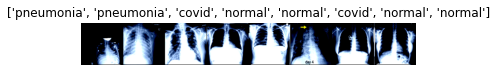

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_databatch(images[70:78], labels[70:78])

In [0]:
new_labels = one_hot_encoding(labels[70:78])
labels = labels[70:78].to(device)
images, new_labels = images[70:78].to(device), new_labels.to(device)
outputs = resnet18(images)                               #--> forward pass
predicted = torch.sigmoid(outputs)
predicted[predicted >= 0.5] = 1
predicted[predicted < 0.5] = 0
predicted_values = one_hot_decoder(predicted,device)

print('Predicted:    ', ' '.join('%5s' % class_names_Train[int(predicted_values[j])]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names_Train[labels[k]]
                              for k in range(len(images))))

Predicted:     pneumonia pneumonia covid normal normal covid normal normal
Ground Truth:  pneumonia pneumonia covid normal normal covid normal normal


In [0]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
Classifier_Layer_size = vgg16.classifier[0].in_features
print(Classifier_Layer_size)

25088


In [0]:
# removing the FC layers

Classifier_features = list(vgg16.classifier.children())[:-7] # Remove last layer
print(Classifier_features)

[]


In [0]:
# Adding FC layers according to assignment

Classifier_features.extend([nn.Linear(Classifier_Layer_size, 4096)])      # My roll number's last two digits are 04
Classifier_features.extend([nn.ReLU(inplace=True)])
Classifier_features.extend([nn.Dropout(p=0.5, inplace=False)])

Classifier_features.extend([nn.Linear(4096, 1024)])      # My roll number's last two digits are 04
Classifier_features.extend([nn.ReLU(inplace=True)])
Classifier_features.extend([nn.Dropout(p=0.5, inplace=False)])

Classifier_features.extend([nn.Linear(1024, len(class_names_Train))])
vgg16.classifier = nn.Sequential(*Classifier_features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# Freeze training for all CNN layers

for parameters in vgg16.features.parameters():
    parameters.requires_grad = True
for parameters in vgg16.classifier.parameters():
    parameters.requires_grad = True
i = 0
for parameters in vgg16.parameters():
    print(i, parameters.requires_grad)
    i+=1


Finished Training


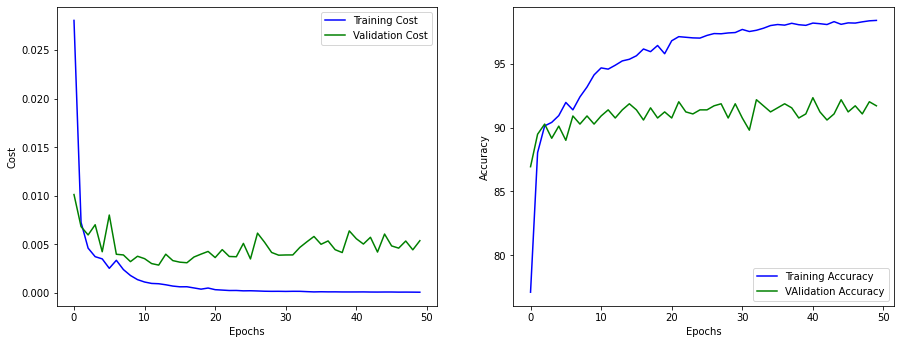

In [0]:
epochs = 50
#Loss_criteria = nn.CrossEntropyLoss()
Loss_criteria = FocalLoss(alpha=0.5,gamma = 1.5)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16_optimizer = optim.SGD(vgg16.parameters(), lr=0.025, momentum=0.90)
#vgg16_optimizer = optim.Adagrad(vgg16.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(vgg16_optimizer, 'max', factor=0.9, patience=2)

vgg16 = training(vgg16, vgg16_optimizer,Loss_criteria, trainloader, validloader, epochs, lr_schedule)

In [0]:
torch.save(vgg16.state_dict(), 'VGG16_SGD_withFL_alpha0.5_G1.5_lr_0.025_FC4096_1024_3_Ass_5_02.pth')

In [0]:
#vgg16.load_state_dict(torch.load('vgg16_entire.pth'))
vgg16.load_state_dict(torch.load('vgg16_focal_loss.pth'))

<All keys matched successfully>

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
Accuracy_ConfusionMatrix(vgg16, validloader, 'Validation', device)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

test_labeling(testloader, test_data, vgg16, device, 'phdee19004_results.csv')
